In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, activations
import numpy as np
import matplotlib.pyplot as plt

In [7]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [8]:
def add_noise(images: np.ndarray, noise_factor: float = 0.2):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0., 1.)

In [9]:
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

In [35]:
def build_conv2d_model():
    input_img = layers.Input(shape=(28, 28, 1))

    # Энкодер
    x = layers.Conv2D(32, (3,3), activation='hard_sigmoid', padding='same', strides=2)(input_img)
    x = layers.Conv2D(64, (3,3), activation='hard_sigmoid', padding='same', strides=2)(x)

    # Декодер
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='hard_sigmoid', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [36]:
def build_separable_model():
    input_img = layers.Input(shape=(28, 28, 1))

    # Энкодер
    x = layers.SeparableConv2D(32, (3,3), activation='hard_sigmoid', padding='same', strides=2)(input_img)
    x = layers.SeparableConv2D(64, (3,3), activation='hard_sigmoid', padding='same', strides=2)(x)

    # Декодер
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='hard_sigmoid', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [30]:
def build_transposed_model():
    input_img = layers.Input(shape=(28, 28, 1))
    
    # Энкодер
    x = layers.Conv2D(32, (3, 3), activation='hard_sigmoid', padding='same', strides=2)(input_img)
    x = layers.Conv2D(64, (3, 3), activation='hard_sigmoid', padding='same', strides=2)(x)
    
    # Декодер
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='hard_sigmoid')(x)
    decoded = layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same', activation='hard_sigmoid')(x)
    
    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [37]:
conv2d_model = build_conv2d_model()
separable_model = build_separable_model()
transposed_model = build_transposed_model()

history_conv2d = conv2d_model.fit(x_train_noisy, x_train,
                                  epochs=7,
                                  batch_size=256,
                                  validation_data=(x_test_noisy, x_test))

history_separable = separable_model.fit(x_train_noisy, x_train,
                                        epochs=7,
                                        batch_size=256,
                                        validation_data=(x_test_noisy, x_test))

history_transposed = transposed_model.fit(x_train_noisy, x_train,
                                        epochs=7,
                                        batch_size=256,
                                        validation_data=(x_test_noisy, x_test))

Epoch 1/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - loss: 0.0961 - val_loss: 0.0293
Epoch 2/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - loss: 0.0237 - val_loss: 0.0136
Epoch 3/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - loss: 0.0131 - val_loss: 0.0106
Epoch 4/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 105ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 5/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 6/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 7/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 1/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - loss: 0.1101 - val_loss: 0.0641
Epoch 2/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.0418 - val_loss: 0.0255
Epoch 3/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.0216 - val_loss: 0.0142
Epoch 4/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - loss: 0.0141 - val_loss: 0.0126
Epoch 5/7
235/235 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:

def plot_results(model: models.Model, name: str, n_samples: int =10):
    decoded_imgs = model.predict(x_test_noisy)
    plt.figure(figsize=(20, 6))
    
    for i in range(n_samples):
        # Оригинал
        ax = plt.subplot(3, n_samples, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis("off")
        
        # Зашумлённое
        ax = plt.subplot(3, n_samples, i + 1 + n_samples)
        plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis("off")
        
        # Восстановленное
        ax = plt.subplot(3, n_samples, i + 1 + 2*n_samples)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    
    plt.suptitle(name)
    plt.tight_layout()
    plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


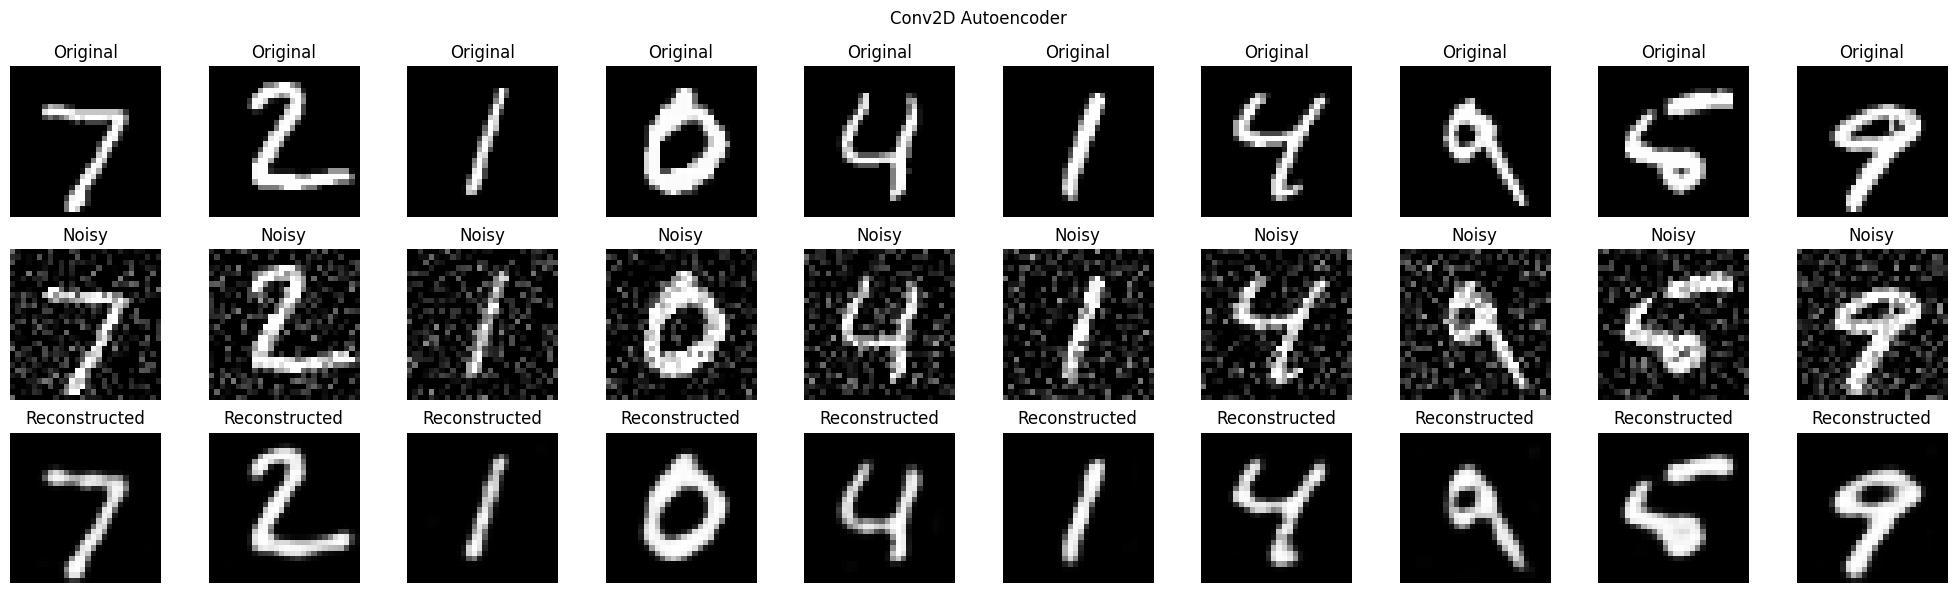

In [41]:
plot_results(conv2d_model, "Conv2D Autoencoder")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


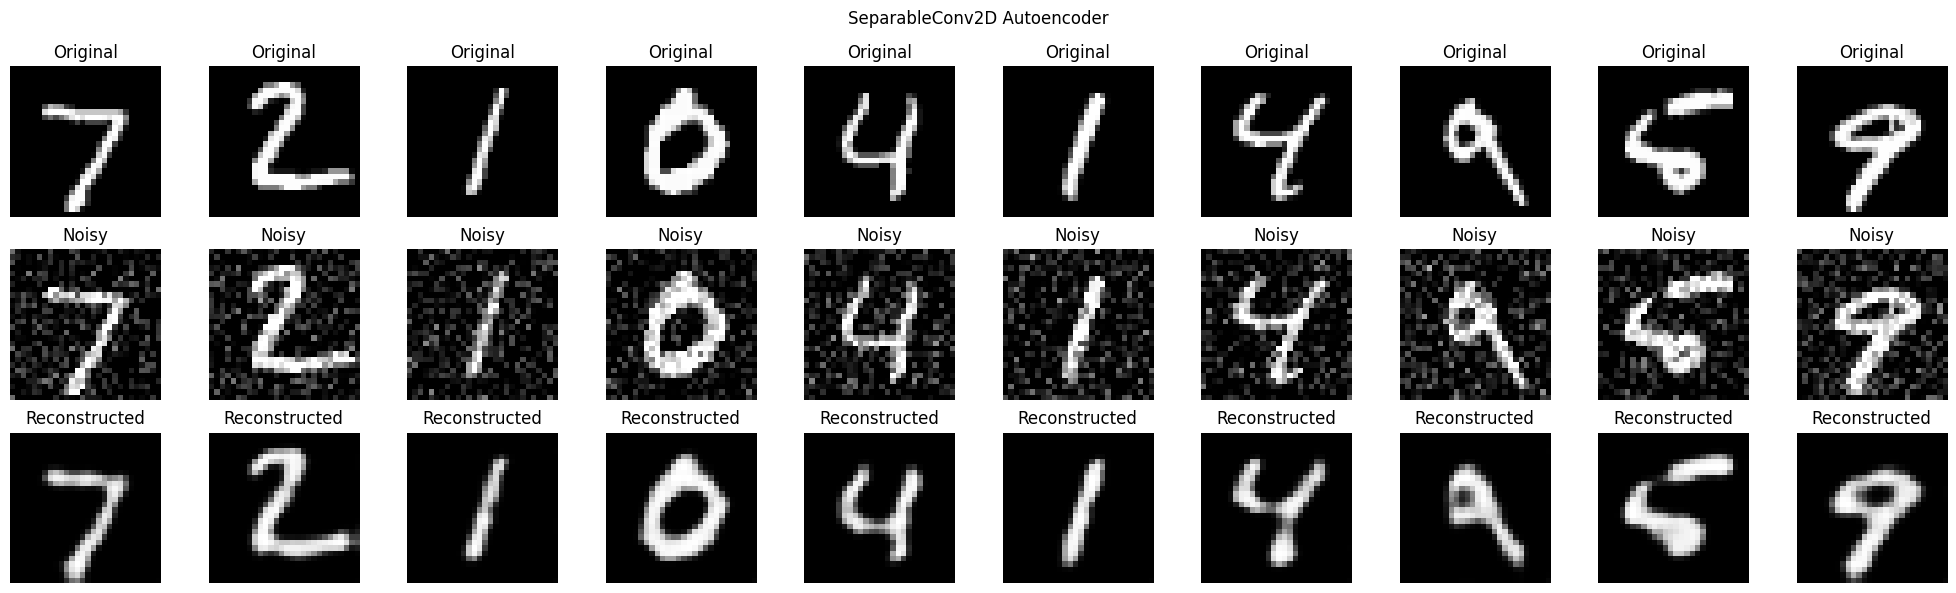

In [42]:
plot_results(separable_model, "SeparableConv2D Autoencoder")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


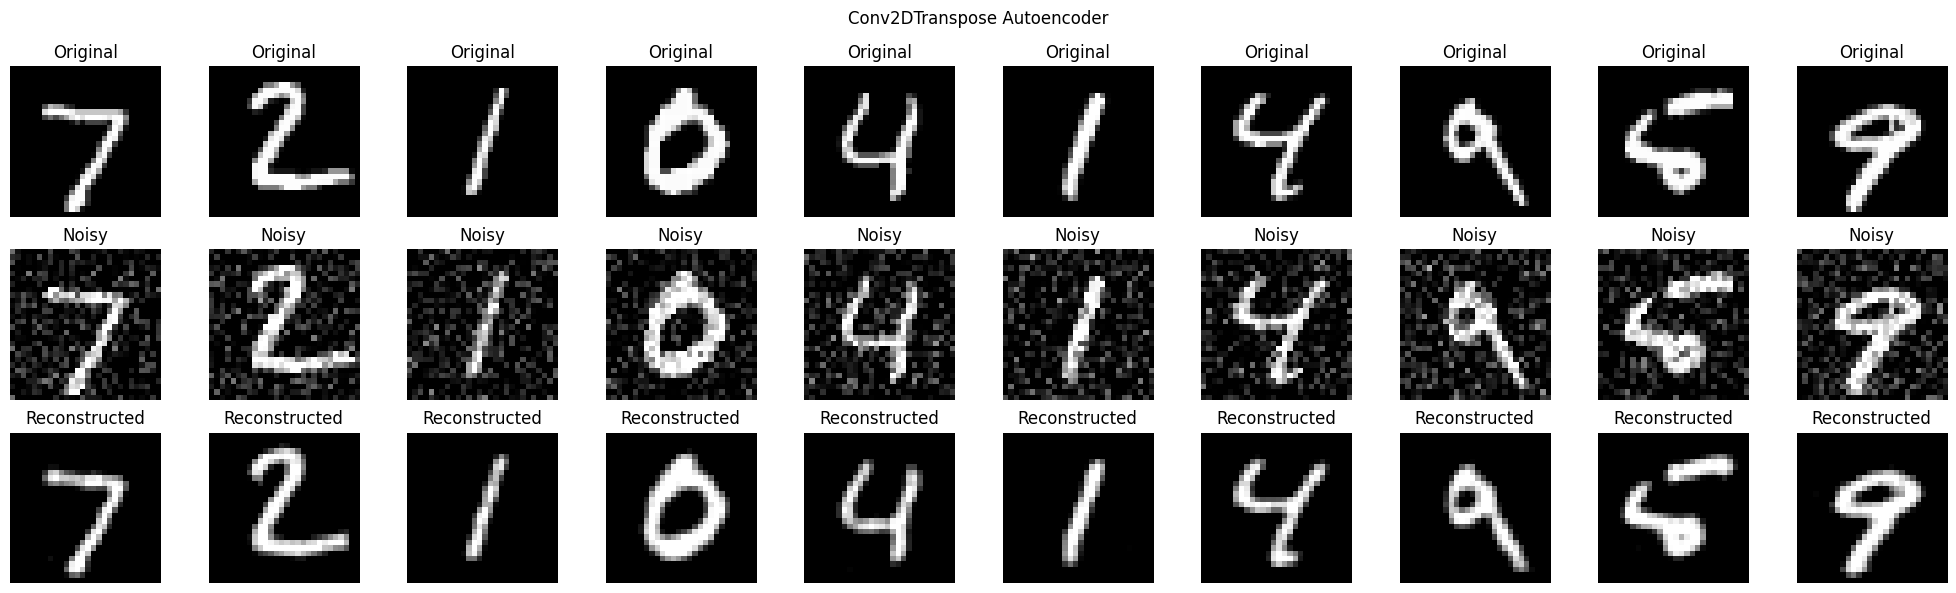

In [43]:
plot_results(transposed_model, "Conv2DTranspose Autoencoder")